
# GANs - Generative Adverserial Networks

+ [Data](#data)
+ [Filtering out the Data for Faster Training on Smaller Dataset](#filter)
+ [Build GAN](#buildingGAN)
    + [Discriminator](#discriminator)
    + [Generator](#generator)
    + [Combining Generator and Discriminator as GAN and compile](#gancombination)
+ [Setting up Training Batches](#trainingbatches)
    + [Discriminator Training Phase (Phase 1)](#phase1)
    + [Generator Training Phase (Phase 2)](#phase2)
+ [Training GAN Loop](#trainingGAN)
+ [Generating Images after training](#generatingaftertraining)

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# <a name=data>Data</a>

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

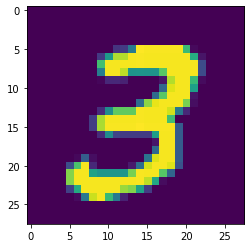

In [8]:
plt.imshow(X_train[7]);

In [10]:
y_train[7]

3

--------

# <a name=filter>Filtering out the Data for Faster Training on Smaller Dataset</a>

## Filtering out zeros only

As we will be focusing on learning GAN, we will choose a single digit number to learn first.

In [12]:
only_zeros = X_train[y_train == 0]

In [13]:
only_zeros.shape

(5923, 28, 28)

In [14]:
X_train.shape

(60000, 28, 28)

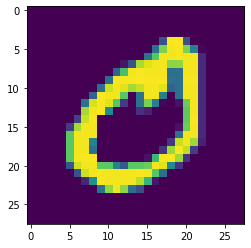

In [17]:
plt.imshow(only_zeros[1]);

------

# <a name=buildingGAN>Build GAN</a>

# <a name=discriminator>Discriminator</a>

+ First we need to flatten images from 2D to 1D
+ we can add any number of hidden layers for Discriminator to be harder to fool, but in our case 2 is enough
+ For the final output layer, activation needs to be `Sigmoid`. Because what discriminator is doing is doing binary classification whether image is Real or Fake.
+ As a result, we need to use `binary_crossentrophy`

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

In [22]:
X_train[0].shape

(28, 28)

In [27]:
discriminator = Sequential()

discriminator.add(Flatten(input_shape=[28,28]))

discriminator.add(Dense(150, activation='relu')) # we can add any number of neruons, based on the problem
discriminator.add(Dense(100, activation='relu'))  # we can add more layers if we want to

# Final Output Layer
discriminator.add(Dense(1, activation='sigmoid')) # one neuron only as output is either 0 or 1

discriminator.compile(optimizer='adam', loss='binary_crossentropy')

-----

# <a name=generator>Generator</a>

+ Generator looks for middle number (in this case 30) which is lowest dimensionality. Example: 784 => 150 => [30] => 150 => 784
+ Actual Generator looks a lot like Decoder Part , where takes in some sort of encoding and expanding it back out to some of output(image) trying to fool the Discriminator.
+ So we have to choose `codings_size` and there is no right or wrong answer. It is essentially `how low do we want to go down. Typically it should be a lot less than original features set.`
    + if we put too small, it can't learn to start off the image.

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
codings_size = 100
# 100 -- 150 -- > 784

generator = Sequential()

generator.add(Dense(100, activation='relu', input_shape=[codings_size])) # number of neurons don't necessarily need to be same as codings_size, we can play around those numbres
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))

generator.add(Reshape([28,28])) # as Discriminator is expecting images in 28x28 dimensions, we need to reshape back to that size

# we don't need to compile Generator
# it is trained through full GAN model.

----

# <a name=gancombination>Combining Generator and Discriminator as GAN and compile</a>
+ GAN full model itself is binary classifier. that's why it uses `binary_crossentrophy`
+ **Discriminator shouldn't be trained in GAN compiling phase.**

In [37]:
GAN = Sequential([generator, discriminator])

In [38]:
discriminator.trainable = False

In [39]:
GAN.compile(optimizer='adam', loss='binary_crossentropy')

-----

**We can see there are two sequential layers in GAN.**

In [40]:
GAN.layers

In [41]:
GAN.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 28, 28)            143634    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 132951    
Total params: 276,585
Trainable params: 143,634
Non-trainable params: 132,951
_________________________________________________________________


In [42]:
GAN.layers[0].summary() # Generator Summary

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               118384    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [44]:
GAN.layers[1].summary() # Discriminator Summary

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               117750    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 132,951
Trainable params: 0
Non-trainable params: 132,951
_________________________________________________________________


--------

# <a name=trainingbatches>Setting up Training Batches</a>



+ The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced.
+ https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle


In [46]:
import tensorflow as tf

In [45]:
batch_size = 32

In [47]:
# my_data = X_train, we can change to what ever data we want to process
my_data = only_zeros

### Shuffle the data

In [53]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000) # we want to shuffle in memory 1K each time

In [54]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

### Actual Setting up Batches
+ we will drop any left over/remainder which ever left after len(my_data) is divided by batch_size
+ we can see there are 185 clean cut batches and some left over.

In [55]:
len(my_data)/batch_size

185.09375

In [56]:
dataset = dataset.batch(batch_size=32, drop_remainder=True).prefetch(1)

-------

# <a name=trainingGAN>Training GAN Loop</a>

**NOTE: The generator never actually sees any real images. It learns by viewing the gradients going back through the discriminator. The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can being to make progress in learning how to generate fake images, in our case, fake zeros.**

In [60]:
[0.0] * 10

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [65]:
[[0.0]]*batch_size + [[1.0]]*batch_size

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0]]

##  <a name=phase1>Discriminator Training Phase (Phase 1)</a>
- create random noise

- produce some images based on created noise (Generator never sees the actual images)

- concat real images + generated images

- create labels for these (0s for fake, 1s for real)

- make discriminator trainable setting True

- train discriminator with features images and labels

##  <a name=phase2>Generator Training Phase (Phase 2)</a>
- create random noise
- in this phase, we want Discriminator to believe that the generated images are real by setting the lables as 1s. (trying to fool it)
- make discriminator trainable setting False, as this is not time to train it.
- train the entire GAN model (basically we are just training Generator through GAN model, as we already set discriminator trainable as False)
- It is just saying based on the created random noise, give me some generated output.

In [57]:
epochs = 1

In [64]:
# Grab the seprate components
generator, discriminator = GAN.layers

In [71]:
for epoch in range(epochs):
    print(f'Currently on Epoch {epoch+1}')
    i = 0
    
    # For every batch in the dataset
    for X_batch in dataset:
        i = i+1
        
        if i%10 == 0:
            print(f'\t Currently on batch number {i} of {len(my_data)//batch_size}')
            
        ##############################################################
        ###########       DISCRIMINATOR TRAINING PHASE           ############
        #############################################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate Image (in terms of numbers based just on noise input)
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)  # we need type cast to float 32 for actual images
        
        # Targets Labels - set to 0s for fake images and 1sfor real images (concat a bunch of 0s list and 1s list) // all in 32 zeros and 32 ones
        y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
        
        # Now it is time to train Discriminator
        discriminator.trainable = True
        
        # Train the discriminator on this current batch
        discriminator.train_on_batch(X_fake_vs_real, y1) # pass features and labels
        
        
        ##############################################################
        ###########             GENERATOR TRAINING PHASE           ############
        #############################################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.0]] * batch_size)
        
        # Discriminator training stop
        discriminator.trainable = False
        
        # Training on GAN model (basically training Generator)
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")         

Currently on Epoch 1
	 Currently on batch number 10 of 185
	 Currently on batch number 20 of 185
	 Currently on batch number 30 of 185
	 Currently on batch number 40 of 185
	 Currently on batch number 50 of 185
	 Currently on batch number 60 of 185
	 Currently on batch number 70 of 185
	 Currently on batch number 80 of 185
	 Currently on batch number 90 of 185
	 Currently on batch number 100 of 185
	 Currently on batch number 110 of 185
	 Currently on batch number 120 of 185
	 Currently on batch number 130 of 185
	 Currently on batch number 140 of 185
	 Currently on batch number 150 of 185
	 Currently on batch number 160 of 185
	 Currently on batch number 170 of 185
	 Currently on batch number 180 of 185
TRAINING COMPLETE


---------

# <a name=generatingaftertraining>Generating Images after training</a>

+ **Why do generated images of GAN looks very similar?**
+ https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same
+ Most likely your generator will only learn to create one type of noisey zero, regardless of what noise is passed in.

In [72]:
noise = tf.random.normal(shape=[10, codings_size]) # give me 10 noisy things

In [73]:
noise.shape

TensorShape([10, 100])

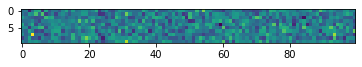

In [76]:
plt.imshow(noise); # this is 100 noise points

In [91]:
# we just pass in those noises to generate images
images = generator(noise)

In [92]:
images.shape # now we get 10 images with 28x28

TensorShape([10, 28, 28])

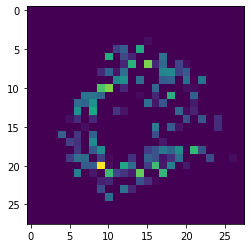

In [93]:
plt.imshow(images[0]);

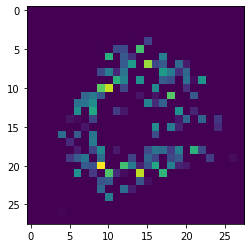

In [94]:
plt.imshow(images[7]);

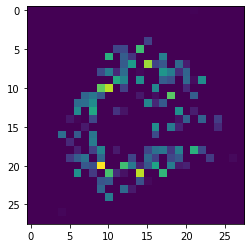

In [95]:
plt.imshow(images[5]);

If we look at the generated images, those are all really similar which is known as `Mode collapse` of GAN (very common problem).

We need very powerful GPUs to achieve realistic results!